# Kaggle Dog Bred Classifier

 
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "0"

set_session(tf.Session(config=config))

num_cores = 1


config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 1})  #GPUs set to zero so we only use CPU
session = tf.Session(config=config)
set_session(session)



Using TensorFlow backend.


In [42]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

from keras.applications import Xception


In [4]:
from io import BytesIO
import cv2
from tqdm import tqdm

import re

import time
from datetime import timedelta

import PIL.Image

from scipy.stats import itemfreq
import scipy.io as sio

from sklearn.model_selection import train_test_split


## Import data - taken from a Kaggle kernel example

### Set up the import

In [5]:
stanford_list_path = "./lists/file_list.mat"
file_list = sio.loadmat(stanford_list_path)

In [6]:
file_list

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:29:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9844.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9924.jpg'], dtype='<U48')]],
       dtype=object),
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],


In [7]:
f = file_list['file_list']
#print(f)
f = np.squeeze(f)
#print(f)
#files = np.squeeze(files)
dog_pattern = re.compile(r'(?<=-)[^\/]+')
file_names = list()
dog_names = list()
for name in f:
    #print(name)
    file_names.append(name[0])
    match = dog_pattern.search(name[0])
    dog_names.append(match.group(0))
    #print(match)
    #dog_names.append(dog_pattern.search(name[0]).group(1))
#file_names = np.array(file_names)
print(file_names[300],dog_names[300])


n02085782-Japanese_spaniel/n02085782_4574.jpg Japanese_spaniel


In [8]:
l = file_list['labels']
labels = list()
for name in l:
    labels.append(name[0])

dog_name_list = dict(list(zip(labels,dog_names)))
print(dog_name_list)


{1: 'Chihuahua', 2: 'Japanese_spaniel', 3: 'Maltese_dog', 4: 'Pekinese', 5: 'Shih-Tzu', 6: 'Blenheim_spaniel', 7: 'papillon', 8: 'toy_terrier', 9: 'Rhodesian_ridgeback', 10: 'Afghan_hound', 11: 'basset', 12: 'beagle', 13: 'bloodhound', 14: 'bluetick', 15: 'black-and-tan_coonhound', 16: 'Walker_hound', 17: 'English_foxhound', 18: 'redbone', 19: 'borzoi', 20: 'Irish_wolfhound', 21: 'Italian_greyhound', 22: 'whippet', 23: 'Ibizan_hound', 24: 'Norwegian_elkhound', 25: 'otterhound', 26: 'Saluki', 27: 'Scottish_deerhound', 28: 'Weimaraner', 29: 'Staffordshire_bullterrier', 30: 'American_Staffordshire_terrier', 31: 'Bedlington_terrier', 32: 'Border_terrier', 33: 'Kerry_blue_terrier', 34: 'Irish_terrier', 35: 'Norfolk_terrier', 36: 'Norwich_terrier', 37: 'Yorkshire_terrier', 38: 'wire-haired_fox_terrier', 39: 'Lakeland_terrier', 40: 'Sealyham_terrier', 41: 'Airedale', 42: 'cairn', 43: 'Australian_terrier', 44: 'Dandie_Dinmont', 45: 'Boston_bull', 46: 'miniature_schnauzer', 47: 'giant_schnauzer

In [9]:

#labels = pd.DataFrame(list(zip(file_names,dog_names,labels)), columns = ['file','breed', 'label'])
labels_raw = pd.DataFrame(list(zip(file_names,dog_names)), columns = ['file','breed'])
labels_raw.sample(5)
#labels[200]
#file = './' + labels[200][0]
#print(file)

,file,breed
5491,n02093647-Bedlington_terrier/n02093647_1600.jpg,Bedlington_terrier
7988,n02096437-Dandie_Dinmont/n02096437_842.jpg,Dandie_Dinmont
9390,n02098286-West_Highland_white_terrier/n0209828...,West_Highland_white_terrier
7496,n02096177-cairn/n02096177_181.jpg,cairn
12354,n02104029-kuvasz/n02104029_1278.jpg,kuvasz


## Create one-hot lables and load data

In [10]:
#df_labels = pd.read_csv('./labels.csv')
#df_submission = pd.read_csv('./sample_submission.csv')   ## <<<< This was the only line used in the original

#targets_series = pd.Series(df_labels['breed'])
#one_hot = pd.get_dummies(targets_series, sparse = True)

#one_hot_labels = np.asarray(one_hot)

In [11]:
#labels_raw = pd.read_csv("./labels.csv", header=0, sep=',', quotechar='"')

#labels_raw.sample(5)


In [12]:
targets_series = pd.Series(labels_raw['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

#### Define target image size

In [13]:
image_resize = 150
X = []
y = []
X_TESTING = []
Train = []
Train_labels = []

#### Load X

In [14]:
i = 0 
for f, breed in tqdm(labels_raw.values):
    img = cv2.imread('./Images/{}'.format(f))
 #   label = one_hot_labels[i]
    Train.append(cv2.resize(img, (image_resize, image_resize)))
 #   Train_labels.append(label)
    i += 1

100%|██████████| 20580/20580 [02:23<00:00, 142.96it/s]


In [15]:
type(Train)

list

In [16]:
#Train_df = pd.DataFrame(list(zip(Train_labels, Train)))
#Train_df

In [17]:
#y_raw = np.array(Train_labels, np.uint8)
X_raw = np.array(Train, np.float32) / 255.


In [18]:
print(X_raw.shape)
#print(y_raw.shape)


(20580, 150, 150, 3)


In [19]:
#num_class = y_train_raw.shape[1]
#num_class

## Limit the number of Dog Breeds in the data in order to simplify the initial calcs

In [20]:
Nber_of_breeds = 120

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
#    print ('Item frequency:')
#    print (labels_freq_pd)
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = X_raw[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 120 main breeds : (20580,)
- The shape of train_filtered dataset is : (20580, 150, 150, 3)


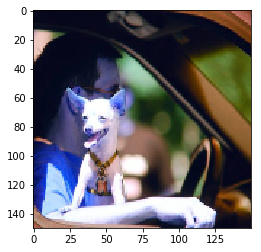

In [21]:
#let's check one image from the train data base
lum_img = train_filtered[100,:,:,:]
plt.imshow(lum_img)
plt.show()

#### Load the lables

### Create 'One-Hot' labels for the data

In [22]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(20580, 1)

In [23]:
#Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [24]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 120
Shape : (20580, 120)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))
labels[0:9]

Breed 0 : Afghan_hound
Breed 1 : African_hunting_dog
Breed 2 : Airedale
Breed 3 : American_Staffordshire_terrier
Breed 4 : Appenzeller
Breed 5 : Australian_terrier
Breed 6 : Bedlington_terrier
Breed 7 : Bernese_mountain_dog
Breed 8 : Blenheim_spaniel
Breed 9 : Border_collie
Breed 10 : Border_terrier
Breed 11 : Boston_bull
Breed 12 : Bouvier_des_Flandres
Breed 13 : Brabancon_griffon
Breed 14 : Brittany_spaniel
Breed 15 : Cardigan
Breed 16 : Chesapeake_Bay_retriever
Breed 17 : Chihuahua
Breed 18 : Dandie_Dinmont
Breed 19 : Doberman
Breed 20 : English_foxhound
Breed 21 : English_setter
Breed 22 : English_springer
Breed 23 : EntleBucher
Breed 24 : Eskimo_dog
Breed 25 : French_bulldog
Breed 26 : German_shepherd
Breed 27 : German_short-haired_pointer
Breed 28 : Gordon_setter
Breed 29 : Great_Dane
Breed 30 : Great_Pyrenees
Breed 31 : Greater_Swiss_Mountain_dog
Breed 32 : Ibizan_hound
Breed 33 : Irish_setter
Breed 34 : Irish_terrier
Breed 35 : Irish_water_spaniel
Breed 36 : Irish_wolfhound
Bre

array([['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua']], dtype=object)

# Create Test/Train data


In [26]:
Train = []

In [27]:
X_raw = []

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_filtered, labels_bin, test_size=0.05, random_state=50)
X_train.shape

(19551, 150, 150, 3)

In [29]:
y_train.shape

(19551, 120)

In [30]:
y_test.shape

(1029, 120)

In [31]:
train_filtered = []

# Create the Keras model

In [55]:
base_model = Xception(input_shape=(image_resize, image_resize, 3), weights='imagenet', include_top=False)

In [56]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_13
13 block2_pool
14 batch_normalization_13
15 add_37
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_14
23 block3_pool
24 batch_normalization_14
25 add_38
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_15
33 block4_pool
34 batch_normalization_15
35 add_39
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_40
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [54]:
print(base_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [33]:
# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(Nber_of_breeds, activation='softmax')(x)

# add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## First, we just train the top layers in order to get those stable first.  After this, we will unfreeze some more and retrain those

In [34]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


### Augmentation - taken from an MNIST CNN kernel 

In [35]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True,
                            rotation_range = 90)

In [36]:
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)

#### Compile it

In [43]:
#model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-5), metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=1e-4, momentum=0.9, decay=0.00, nesterov=True), metrics=["accuracy"])
#keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

### Run it!

In [50]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                           #steps_per_epoch=500,
                           epochs=5, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]), 
                           #initial_epoch = 1,                           
                           callbacks=[annealer]
                          )

Epoch 1/5
 - 229s - loss: 3.3404 - acc: 0.2326 - val_loss: 2.6011 - val_acc: 0.3600
Epoch 2/5
 - 239s - loss: 3.3058 - acc: 0.2348 - val_loss: 2.5808 - val_acc: 0.3560
Epoch 3/5
 - 239s - loss: 3.3165 - acc: 0.2396 - val_loss: 2.5869 - val_acc: 0.3600
Epoch 4/5
 - 242s - loss: 3.2932 - acc: 0.2410 - val_loss: 2.5711 - val_acc: 0.3520
Epoch 5/5
 - 238s - loss: 3.2982 - acc: 0.2367 - val_loss: 2.5734 - val_acc: 0.3600


## The top layers are now trained, so we go back and unfreeze the last Xception block to train further

In [57]:
# we chose to train the top 1 xception block, i.e. we will freeze
# the first 126 layers (0-125) and unfreeze the rest:
for layer in model.layers[:126]:
   layer.trainable = False
for layer in model.layers[126:]:
   layer.trainable = True

In [61]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=["accuracy"])


In [68]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                           #steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]) 
                           #,initial_epoch = 1                           
                           #,callbacks=[annealer]
                          )

Epoch 1/50
 - 248s - loss: 3.0693 - acc: 0.2698 - val_loss: 2.4873 - val_acc: 0.3600
Epoch 2/50
 - 259s - loss: 3.0832 - acc: 0.2679 - val_loss: 2.4893 - val_acc: 0.3720
Epoch 3/50
 - 255s - loss: 3.0699 - acc: 0.2651 - val_loss: 2.4920 - val_acc: 0.3760
Epoch 4/50
 - 255s - loss: 3.0436 - acc: 0.2715 - val_loss: 2.4795 - val_acc: 0.3800
Epoch 5/50
 - 255s - loss: 3.0295 - acc: 0.2701 - val_loss: 2.4726 - val_acc: 0.3720
Epoch 6/50
 - 255s - loss: 3.0366 - acc: 0.2715 - val_loss: 2.4765 - val_acc: 0.3720
Epoch 7/50
 - 255s - loss: 3.0425 - acc: 0.2679 - val_loss: 2.4684 - val_acc: 0.3760
Epoch 8/50
 - 255s - loss: 3.0260 - acc: 0.2721 - val_loss: 2.4620 - val_acc: 0.3680
Epoch 9/50
 - 256s - loss: 3.0104 - acc: 0.2734 - val_loss: 2.4659 - val_acc: 0.3720
Epoch 10/50
 - 256s - loss: 3.0241 - acc: 0.2750 - val_loss: 2.4548 - val_acc: 0.3680
Epoch 11/50
 - 256s - loss: 3.0080 - acc: 0.2722 - val_loss: 2.4503 - val_acc: 0.3720
Epoch 12/50
 - 256s - loss: 2.9893 - acc: 0.2801 - val_loss: 2.

## Evaluate

We only used a subset of the validation set during training, to save time. Now let's check performance on the whole validation set.


In [40]:

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


Final loss: 2.7531, final accuracy: 0.3362


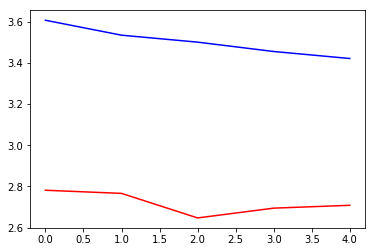

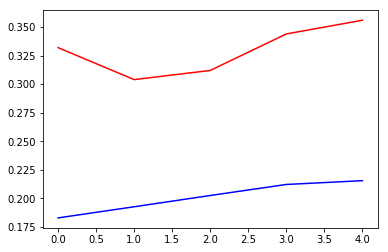

In [41]:

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
model.summary()

In [ ]:
model.summary()

#### Load X_TESTING

In [ ]:
#for f in tqdm(df_submission['id'].values):
#    img = cv2.imread('../input/test/{}.jpg'.format(f))
#    X_TESTING.append(cv2.resize(img, (im_size, im_size)))
#X_TESTING  = np.array(x_test, np.float32) / 255.

In [44]:
#for f in tqdm(df_submission['id'].values):
X_TESTING = []
img = cv2.imread('./Henry_cropped.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry2.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry3.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry4.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry5.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry7.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Amanda.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Corinne.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Jing.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Karen.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Labrador.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Pam.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
X_TESTING  = np.array(X_TESTING, np.float32) / 255.

In [69]:
prediction = model.predict(X_TESTING, verbose=1)

12/12 [==============================] - 0s 22ms/step


In [70]:
sub = pd.DataFrame(prediction)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
#sub.insert(0, 'id', labels_raw['id'])
actual_names = ['Henry1','Henry2','Henry3','Henry4','Henry5','Henry7', 'Amanda','Corinne','Jing','Karen','Labrador','Pam']
sub.insert(0, 'id', actual_names)

sub

,id,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
0,Henry1,0.001410,1.732044e-07,0.006654,0.000066,6.806543e-06,8.804908e-04,0.004713,2.197523e-05,0.000020,...,5.017593e-07,0.002200,0.071605,0.000351,0.000216,0.001051,1.110840e-04,1.112361e-03,2.541589e-04,0.001223
1,Henry2,0.001196,2.298815e-05,0.006073,0.003312,5.074109e-06,1.281871e-04,0.036795,5.859239e-07,0.000893,...,3.586862e-06,0.000281,0.005475,0.001566,0.000337,0.020371,6.356352e-06,4.248322e-03,5.597149e-04,0.000653
2,Henry3,0.000171,2.392988e-08,0.001864,0.000010,1.986347e-09,3.413307e-06,0.757639,2.492161e-08,0.000002,...,6.648882e-08,0.000001,0.010575,0.006695,0.000084,0.016539,4.854890e-07,1.700588e-04,8.118982e-07,0.001963
3,Henry4,0.000046,3.353202e-07,0.001562,0.000016,3.783148e-07,2.307303e-05,0.001483,3.695790e-07,0.000149,...,6.330567e-07,0.000046,0.687485,0.000225,0.000007,0.003568,1.897024e-06,2.768031e-04,2.317630e-05,0.002486
4,Henry5,0.000155,2.828889e-05,0.000647,0.031515,2.030679e-04,9.028135e-06,0.000719,9.375477e-05,0.001775,...,4.687821e-05,0.000002,0.011963,0.000670,0.000037,0.000188,3.597373e-04,4.035811e-03,1.734081e-02,0.002700
5,Henry7,0.000481,6.368969e-07,0.028514,0.000481,2.941754e-06,2.415247e-03,0.009560,4.758402e-05,0.000072,...,5.560953e-06,0.005447,0.204514,0.002817,0.000189,0.050166,1.590388e-05,2.936666e-04,1.750392e-04,0.004068
6,Amanda,0.000048,3.394395e-04,0.000037,0.008793,1.080021e-03,3.742823e-05,0.000355,1.214976e-04,0.000198,...,1.632317e-03,0.000383,0.000203,0.000124,0.000814,0.000154,1.411647e-01,3.798556e-03,3.527903e-03,0.000052
7,Corinne,0.000115,7.262089e-07,0.000002,0.000015,3.249609e-06,5.907128e-07,0.000018,3.141329e-06,0.000005,...,3.758368e-05,0.000005,0.000046,0.003030,0.000001,0.005433,2.032812e-05,1.707373e-05,3.659529e-05,0.000007
8,Jing,0.000035,3.046753e-04,0.000040,0.000104,9.684453e-05,2.153819e-03,0.000020,2.507883e-04,0.008687,...,1.226160e-05,0.000106,0.004923,0.000038,0.153013,0.000008,2.050088e-04,8.118663e-07,1.041974e-04,0.051396
9,Karen,0.001146,1.777952e-03,0.011182,0.006300,9.162056e-03,1.145190e-03,0.000160,2.697066e-02,0.008558,...,1.246822e-02,0.001598,0.000214,0.006395,0.000964,0.000454,5.302313e-03,3.436676e-03,1.539328e-02,0.001102


In [71]:
sub = sub.set_index('id')
sub


,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,Border_collie,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
id,,,,,,,,,,,,,,,,,,,,,
Henry1,0.001410,1.732044e-07,0.006654,0.000066,6.806543e-06,8.804908e-04,0.004713,2.197523e-05,0.000020,2.783095e-05,...,5.017593e-07,0.002200,0.071605,0.000351,0.000216,0.001051,1.110840e-04,1.112361e-03,2.541589e-04,0.001223
Henry2,0.001196,2.298815e-05,0.006073,0.003312,5.074109e-06,1.281871e-04,0.036795,5.859239e-07,0.000893,8.609721e-06,...,3.586862e-06,0.000281,0.005475,0.001566,0.000337,0.020371,6.356352e-06,4.248322e-03,5.597149e-04,0.000653
Henry3,0.000171,2.392988e-08,0.001864,0.000010,1.986347e-09,3.413307e-06,0.757639,2.492161e-08,0.000002,2.225280e-07,...,6.648882e-08,0.000001,0.010575,0.006695,0.000084,0.016539,4.854890e-07,1.700588e-04,8.118982e-07,0.001963
Henry4,0.000046,3.353202e-07,0.001562,0.000016,3.783148e-07,2.307303e-05,0.001483,3.695790e-07,0.000149,1.725181e-06,...,6.330567e-07,0.000046,0.687485,0.000225,0.000007,0.003568,1.897024e-06,2.768031e-04,2.317630e-05,0.002486
Henry5,0.000155,2.828889e-05,0.000647,0.031515,2.030679e-04,9.028135e-06,0.000719,9.375477e-05,0.001775,9.668379e-04,...,4.687821e-05,0.000002,0.011963,0.000670,0.000037,0.000188,3.597373e-04,4.035811e-03,1.734081e-02,0.002700
Henry7,0.000481,6.368969e-07,0.028514,0.000481,2.941754e-06,2.415247e-03,0.009560,4.758402e-05,0.000072,1.716752e-05,...,5.560953e-06,0.005447,0.204514,0.002817,0.000189,0.050166,1.590388e-05,2.936666e-04,1.750392e-04,0.004068
Amanda,0.000048,3.394395e-04,0.000037,0.008793,1.080021e-03,3.742823e-05,0.000355,1.214976e-04,0.000198,4.354256e-04,...,1.632317e-03,0.000383,0.000203,0.000124,0.000814,0.000154,1.411647e-01,3.798556e-03,3.527903e-03,0.000052
Corinne,0.000115,7.262089e-07,0.000002,0.000015,3.249609e-06,5.907128e-07,0.000018,3.141329e-06,0.000005,1.678435e-05,...,3.758368e-05,0.000005,0.000046,0.003030,0.000001,0.005433,2.032812e-05,1.707373e-05,3.659529e-05,0.000007
Jing,0.000035,3.046753e-04,0.000040,0.000104,9.684453e-05,2.153819e-03,0.000020,2.507883e-04,0.008687,7.115369e-03,...,1.226160e-05,0.000106,0.004923,0.000038,0.153013,0.000008,2.050088e-04,8.118663e-07,1.041974e-04,0.051396


In [72]:
nlargest = 10
order = np.argsort(-sub.values, axis=1)[:, :nlargest]
result = pd.DataFrame(sub.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=sub.index)

print(result)

                                 top1                         top2  \
id                                                                   
Henry1               Lakeland_terrier  soft-coated_wheaten_terrier   
Henry2                Irish_wolfhound             golden_retriever   
Henry3             Bedlington_terrier                     komondor   
Henry4    soft-coated_wheaten_terrier         Old_English_sheepdog   
Henry5             Labrador_retriever    Staffordshire_bullterrier   
Henry7    soft-coated_wheaten_terrier             Lakeland_terrier   
Amanda                    Boston_bull                  toy_terrier   
Corinne                       Samoyed                   Pomeranian   
Jing                 Sealyham_terrier          miniature_schnauzer   
Karen                      Rottweiler        flat-coated_retriever   
Labrador             golden_retriever                      clumber   
Pam                               pug                        boxer   

                   

In [73]:
model.save('dog_classifier.h5')